# Medalpaca LLM

In [1]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()


In [2]:
import os
os.environ["HF_HOME"] = "/media/jeyanth-s/DevDrive/AI_Workspace/projects/Heart Disease Project Repository/Heart-Disease-Prediction---Cognitives/hfcache"
os.makedirs("/media/jeyanth-s/DevDrive/AI_Workspace/projects/Heart Disease Project Repository/Heart-Disease-Prediction---Cognitives/Models/offload", exist_ok=True)


In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os

model_id = "medalpaca/medalpaca-7b"

# Define local offload folder (you can change this path as needed)
offload_dir = "/media/jeyanth-s/DevDrive/AI_Workspace/projects/Heart Disease Project Repository/Heart-Disease-Prediction---Cognitives/Models/offload"
os.makedirs(offload_dir, exist_ok=True)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load model with offloading if needed
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16 if torch.cuda.is_available() else "auto",
    offload_folder=offload_dir,     # 💾 Required for safe disk offload
    cache_dir="/media/jeyanth-s/DevDrive/AI_Workspace/projects/Heart Disease Project Repository/Heart-Disease-Prediction---Cognitives/hfcache"          # Optional: custom cache directory
)

# Test a prompt
prompt = "Summarize the risk factors for heart disease in a 60-year-old male with high cholesterol and hypertension."
inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# Generate response
outputs = model.generate(**inputs, max_new_tokens=150)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Summarize the risk factors for heart disease in a 60-year-old male with high cholesterol and hypertension.
asked by Anonymous on February 28, 2011
Which of the following is a risk factor for heart disease? High cholesterol.
asked by Anonymous on February 2, 2011


In [4]:
input_data = {
    "age": 22000,
    "gender": 1,
    "height": 165,
    "weight": 78.0,
    "ap_hi": 140,
    "ap_lo": 90,
    "cholesterol": 2,
    "gluc": 1,
    "smoke": 0,
    "alco": 0,
    "active": 1
}


In [5]:
def engineer_features(data):
    # Convert raw age
    data["age_years"] = round(data["age"] / 365.25, 2)
    
    # Rename columns
    data["height_cm"] = data.pop("height")
    data["weight_kg"] = data.pop("weight")
    
    # Derived features
    data["bmi"] = round(data["weight_kg"] / ((data["height_cm"] / 100) ** 2), 2)
    data["pulse_pressure"] = data["ap_hi"] - data["ap_lo"]
    data["hypertension"] = int(data["ap_hi"] >= 140 or data["ap_lo"] >= 90)
    
    # Remove the raw 'age' field — not used by model
    data.pop("age", None)
    
    return data


In [6]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import pandas as pd

# Load models
xgb_model = xgb.Booster()
xgb_model.load_model("/media/jeyanth-s/DevDrive/AI_Workspace/projects/Heart Disease Project Repository/Heart-Disease-Prediction---Cognitives/Models/xgboost_model.json")

lgb_model = lgb.Booster(model_file="/media/jeyanth-s/DevDrive/AI_Workspace/projects/Heart Disease Project Repository/Heart-Disease-Prediction---Cognitives/Models/lightgbm_model.txt")
cat_model = CatBoostClassifier()
cat_model.load_model("/media/jeyanth-s/DevDrive/AI_Workspace/projects/Heart Disease Project Repository/Heart-Disease-Prediction---Cognitives/Models/catboost_model.cbm")


# Prepare input
features = engineer_features(input_data.copy())
df = pd.DataFrame([features])
expected_order = [
    'gender', 'height_cm', 'weight_kg', 'ap_hi', 'ap_lo', 'cholesterol',
    'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi',
    'pulse_pressure', 'hypertension'
]

df = df[expected_order]
xgb_pred = xgb_model.predict(xgb.DMatrix(df))[0]
lgb_pred = lgb_model.predict(df)[0]
cat_pred = cat_model.predict(df)[0]

print("XGBoost:", int(xgb_pred))
print("LightGBM:", int(lgb_pred))
print("CatBoost:", int(cat_pred))

ensemble_result = round((xgb_pred + lgb_pred + cat_pred) / 3)


XGBoost: 0
LightGBM: 0
CatBoost: 1


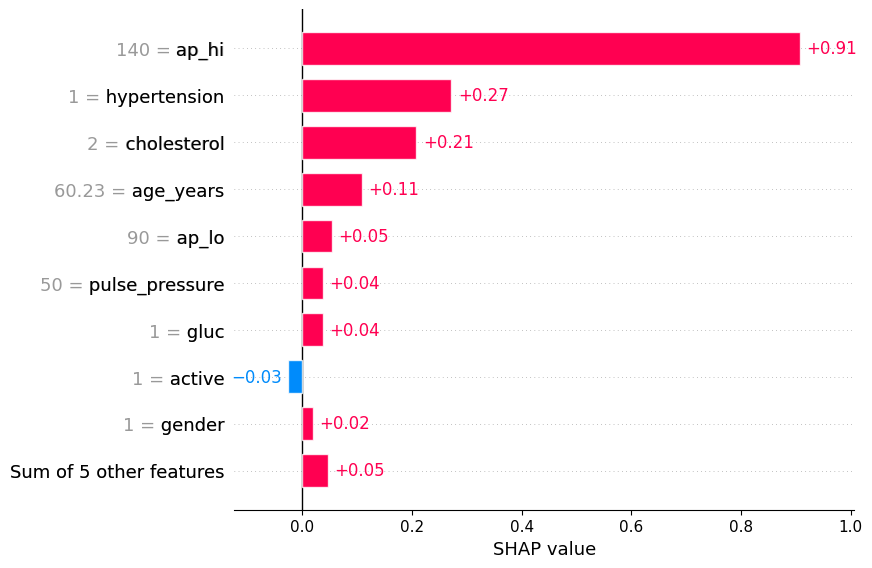

In [7]:
import shap
explainer = shap.Explainer(cat_model)
shap_values = explainer(df)
shap.plots.bar(shap_values[0])  # optional: show top contributing features


In [ ]:
prompt = f"""
You are a clinical AI assistant. Based on the following patient features and model predictions, provide a concise medical summary.

Patient Data:
{features}

Predictions:
- XGBoost: {int(xgb_pred)}
- LightGBM: {int(lgb_pred)}
- CatBoost: {int(cat_pred)}
- Ensemble Final: {ensemble_result}

Summarize in clinical language.
"""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=200)

summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(summary)



You are a clinical AI assistant. Based on the following patient features and model predictions, provide a concise medical summary.

Patient Data:
{'gender': 1, 'ap_hi': 140, 'ap_lo': 90, 'cholesterol': 2, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1, 'age_years': 60.23, 'height_cm': 165, 'weight_kg': 78.0, 'bmi': 28.65, 'pulse_pressure': 50, 'hypertension': 1}

Predictions:
- XGBoost: 0
- LightGBM: 0
- CatBoost: 1
- Ensemble Final: 1

Summarize in clinical language.

The patient is at risk of hypertension.


# BioMistral

In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model="BioMistral/BioMistral-7B")
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe(messages)